In [1]:
# -*- coding: utf-8 -*-

#import the libraries and declare settings
import os
import requests
import nltk
import pandas as pd
import numpy as np
import re
import string
#import sklearn
from nltk.corpus import stopwords
import random
from sklearn.utils import shuffle
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import gensim
from collections import Counter
#from nltk.tokenize import word_tokenize
#import necessary libraries for model training and evaluations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from mlxtend.evaluate import bias_variance_decomp
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils import resample
#visualization
import matplotlib.pyplot as plt
from sklearn import metrics
import wordcloud
from wordcloud import WordCloud
import multidict as multidict
#pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
pd.set_option('display.width', 100000)

In [2]:
# download files for text cleaning
nltk.download('punkt')
nltk.download('stopwords')
nltk.download("wordnet")

#Use of utf8 to handle special characters if available in the English books
url_label_pairs = [
    ("https://www.gutenberg.org/cache/epub/36/pg36.txt.utf8", "The War of the Worlds","H. G. Wells","Science Fiction","a"),
    ("https://www.gutenberg.org/cache/epub/18857/pg18857.txt.utf8", "A Journey to the Centre of the Earth","Jules Verne","Science Fiction","b"),
    ("https://www.gutenberg.org/cache/epub/10148/pg10148.txt.utf8","The Merry Adventures of Robin Hood","Howard Pyle","Fantasy","c"),
    ("https://www.gutenberg.org/cache/epub/12753/pg12753.txt.utf8","The Legends of King Arthur and His Knights","Sir James Knowle & Sir Thomas Malory","Fantasy","d"),
    ("https://www.gutenberg.org/cache/epub/1998/pg1998.txt.utf8","Thus Spake Zarathustra: A Book for All and None","Friedrich Wilhelm Nietzsche","Philosophy","e"),
    ("https://www.gutenberg.org/cache/epub/8438/pg8438.txt.utf8", "The Ethics of Aristotle","Aristotle","Philosophy","f")]

start_line_part1 = "*** START OF THE PROJECT GUTENBERG EBOOK "
end_line_part2 = "*** END OF THE PROJECT GUTENBERG EBOOK "
all_partitions = []

columns_names = ['book_name','label','text','target_author','target_genre']
df_all_partitions = pd.DataFrame(columns=columns_names)

def text_cleaning(text, flg_lemm=True, flg_stemm=False):
    # Remove all the contents which are not letters, i.e, remove all the punctuations/numbers
    # Get the alphabetic words that have 3 or more letters
    text = re.findall(r"[a-zA-Z]{3,}", text)
    # Convert to lowercase to uniform the words
    words = [word.lower() for word in text if word.isalnum()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Remove most meaningless frequent words
    #lst_remove_words = ["martian", "uncle" , "sir", "one", "man", "could", "saw", "said", "would", "also", "like", "good"]
    #words = [word for word in words if word not in lst_remove_words]
    # Lemmatize the words
    if flg_lemm == True:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    # Stemming the words, we found stemming doesn't improve the model accuracy (such as SVM)
    if flg_stemm == True:
        stemmer = nltk.stem.porter.PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    return words

def get_word_count(url):
    response = requests.get(url)
    book_text = response.text
    book_text = book_text.partition(start_line_part1)[2] # get content after part 1
    book_text = book_text.partition(end_line_part2)[0] # get content before part 2
    word = text_cleaning(book_text)
    return len(word)

def split_into_chunks(text, words_per_partition=100):
    # Initialize an empty list to store the chunks
    chunks = []
    # Iterate over the tokens and create chunks
    current_chunk = []
    for word in text:
        current_chunk.append(word)

        # Check if the chunk size is reached
        if len(current_chunk) == words_per_partition:
            # Add the current chunk to the list of chunks
            chunks.append(" ".join(current_chunk))
            # Reset the current chunk
            current_chunk = []
    # Add the last chunk if it's length is greater than 100
    if len(current_chunk)>=words_per_partition:
        chunks.append(" ".join(current_chunk))
    return chunks

def create_partitions(url, book_name, genre, author, label):
    # Load the book from Gutenberg
    response = requests.get(url)
    book_text = response.text
    book_text = book_text.partition(start_line_part1)[2] # get content after part 1
    book_text = book_text.partition(end_line_part2)[0] # get content before part 2
    words = text_cleaning(book_text, flg_lemm=True, flg_stemm=False)

    body_book = split_into_chunks(text=words, words_per_partition=100)

    glo_partitions = []
    for i in range(len(body_book)):
        glo_partitions.append({'book_name':book_name,'label': f'{label}_{i+1}', 'text': body_book[i], 'target_author':author, 'target_genre':genre})

    return glo_partitions

def check_length_of_book():
    for i in range(len(url_label_pairs)):
        len_book = get_word_count(url_label_pairs[i][0])
        # Check if the book is long enough
        if len_book < 20000:
            print(url_label_pairs[i][0])
            raise ValueError("The selected book is not long enough for the requested number of partitions!")
        else:
            print('Length:',len_book,url_label_pairs[i][0])

def get_all_partitions():
    random.seed(100)
    for url, book_name, author, genre, label in url_label_pairs:
        partitions = create_partitions(url, book_name, genre, author, label)
        temporary_df = pd.DataFrame(partitions)
        # To get the same partitions for each run.
        index_calc=random.sample(range(0, len(partitions)),200)
        temporary_df = temporary_df.iloc[index_calc]
        global df_all_partitions
        df_all_partitions = pd.concat([df_all_partitions,temporary_df], ignore_index=True)

# def frequency_distribution_line_chart():
#     author = df_all_partitions['target_author'].unique()
#     fre_author = []
#     for i in range(len(author)):
#         fre_author.append(nltk.FreqDist(word for text in df_all_partitions[df_all_partitions["target_author"] == author[i]]["text"] for word in text.lower().split()))

#     for i in range(len(fre_author)):
#         print('Author Name:', author[i])
#         plt.subplots(figsize=(10,6))
#         fre_author[i].plot(30)
#         plt.show()
#define a function to display the frenquency distribution of ngram
def fun_freqent_ngram(df, top=10, n = 2, num_columns = 2):
  top = top
  authors = df['target_author'].unique()
  num_rows = (len(authors) + num_columns - 1) // num_columns
  fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
  for i, author in enumerate(authors):
    row_position = i // num_columns
    col_position = i % num_columns
    author_texts = df[df['target_author'] == author]['text']
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngrams_matrix = vectorizer.fit_transform(author_texts)
    ngrams_list = vectorizer.get_feature_names_out()
    # Sum up n-gram occurrences
    ngrams_count = ngrams_matrix.sum(axis=0)
    # Create a Counter for n-grams
    ngrams_counter = Counter(dict(zip(ngrams_list, ngrams_count.A1)))
    sorted_ngrams = dict(sorted(ngrams_counter.items(), key=lambda x: x[1], reverse=True))
    # Plot frequency chart, top 10
    axs[row_position, col_position].barh(*zip(*list(sorted_ngrams.items())[:top][::-1]))
    axs[row_position, col_position].set_title(f'Frequency Chart for {author}')
    axs[row_position, col_position].set_xlabel('Frequency')
    axs[row_position, col_position].set_ylabel(f'{n}-gram')

  plt.tight_layout()
  plt.show()

# BOW (Bag of Words)
def bow_transform():
    # Create a CountVectorizer instance
    vectorizer = CountVectorizer()
    # Fit and transform the text data
    bow_matrix = vectorizer.fit_transform(df_all_partitions['text'])
    # Convert the sparse matrix to a DataFrame
    bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df_bow = pd.concat([df_all_partitions, bow_df], axis=1)
    return df_bow

# TF-IDF (Term Frequency-Inverse Document Frequency)
def tfidf_transform():
    # Create a TfidfVectorizer instance
    vectorizer = TfidfVectorizer()
    # Fit and transform the text data
    tfidf_matrix = vectorizer.fit_transform(df_all_partitions['text'])
    # Convert the sparse matrix to a DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df_tfidf = pd.concat([df_all_partitions, tfidf_df], axis=1)
    return df_tfidf

# N-gram, initialize the CountVectorizer with tri-gram
def ngram_transform(ngram_range=(3,3)):
    # Create a CountVectorizer instance with the specified n-gram range
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    # Fit and transform the text data
    ngram_matrix = vectorizer.fit_transform(df_all_partitions['text'])
    # Convert the sparse matrix to a DataFrame
    ngram_df = pd.DataFrame(ngram_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df_ngram = pd.concat([df_all_partitions, ngram_df], axis=1)
    return df_ngram

#split dataset into train (80%) and test(20%)
#df_bow, df_tfidf, df_3gram and  df_2gram
# use stratified sampling, book names are unique
def stratified_sample(df):
    # Create a combined target variable with author and genre
    df['combined_label'] = df['target_author'].astype(str) + '_' + df['target_genre'].astype(str)
    df['encoded_label'] = df['combined_label'].replace(['H. G. Wells_Science Fiction', 'Jules Verne_Science Fiction','Howard Pyle_Fantasy',
                                   'Sir James Knowle & Sir Thomas Malory_Fantasy',
                                  'Friedrich Wilhelm Nietzsche_Philosophy','Aristotle_Philosophy'],
                        [0,1,2,3,4,5], inplace=False)
    y = df['encoded_label']  # Target variable
    x = df.drop(['target_author','target_genre','book_name','label','encoded_label'], axis=1)
    # set a specific random state for reproducibility
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, stratify=y, random_state= 10)

    return train_x, test_x, train_y, test_y


def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}
    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

def makeImage(text):
    wc = WordCloud(background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(text)
    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def word_cloud_frequency():
    author = df_all_partitions['target_author'].unique()
    fre_author = []
    for i in range(len(author)):
        df_author = df_all_partitions[df_all_partitions['target_author'] == author[i]]
        print('Author Name:', author[i])
        join_partitions_words = ' '.join(df_author['text'])
        makeImage(getFrequencyDictForText(join_partitions_words))

#check if book length are enough for partitioning
#check_length_of_book()
#get the sample data
get_all_partitions()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#df_all_partitions.tail()
df_all_partitions.head()

,book_name,label,text,target_author,target_genre
0,The War of the Worlds,a_75,swaying writhing gust dying storm throwing red...,H. G. Wells,Science Fiction
1,The War of the Worlds,a_236,another planet moment touched emotion beyond c...,H. G. Wells,Science Fiction
2,The War of the Worlds,a_233,advisable kill lest action attracted attention...,H. G. Wells,Science Fiction
3,The War of the Worlds,a_90,horseback hunting three four black government ...,H. G. Wells,Science Fiction
4,The War of the Worlds,a_202,beyond true nature dexterous workman dawned up...,H. G. Wells,Science Fiction


In [4]:
#model training
pd.set_option('display.max_colwidth', None)
#SVM model
def svm_algo(train_x,test_x,train_y,test_y):
  X_train = train_x.drop(['combined_label','text'], axis=1)
  X_test = test_x.drop(['combined_label','text'], axis=1)
  clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
  clf.fit(X_train, train_y)
  y_pred = clf.predict(X_test)
  print('Accuracy: {:.2f}'.format(accuracy_score(test_y, y_pred)))
  print('')
  print('Confusion Matrix:')
  cm = confusion_matrix(test_y, y_pred, labels=clf.classes_)
  #print(cm)
  my_labels = ['H. G. Wells_Science Fiction', 'Jules Verne_Science Fiction','Howard Pyle_Fantasy',
                                   'Sir James Knowle & Sir Thomas Malory_Fantasy',
                                  'Friedrich Wilhelm Nietzsche_Philosophy','Aristotle_Philosophy']
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = clf.classes_)
  disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
  plt.show()
  print('Classification Report:')
  print(classification_report(test_y, y_pred, target_names= my_labels))
  print('')
  #Bias and Variance
  avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf, np.array(X_train),
                                                              np.array(train_y), np.array(X_test),
                                                              np.array(test_y), loss='0-1_loss',
                                                              random_seed=123, num_rounds = 50)

  print('Average expected loss: %.3f' % avg_expected_loss)
  print('Average bias: %.3f' % avg_bias)
  print('Average variance: %.3f' % avg_var)
  print('')
  print('Misclassified Obs:')
  misclassified_indices = np.where(test_y != y_pred)[0]
  misclassified_data =[]
  for i in misclassified_indices:
    text = test_x.iloc[i,0]
    combined_label = test_x['combined_label'].iloc[i]
    true_label = test_y.iloc[i]
    pred_label = y_pred[i]
    misclassified_data.append({'text': text, 'combined_label':combined_label, 'true_label':true_label, 'pred_label':pred_label})
  misclassified_data = pd.DataFrame(misclassified_data)
  print(misclassified_data.head())
  return clf, misclassified_data

#Naive Bayes
def naive_bayes_algo(train_x,test_x,train_y,test_y):
    X_train = train_x.drop(['combined_label','text'], axis=1)
    X_test = test_x.drop(['combined_label','text'], axis=1)
    naive_bayes_model = MultinomialNB()
    nb_model = naive_bayes_model.fit(X_train, train_y)
    y_pred = nb_model.predict(X_test)

    print('Accuracy: {:.2f}'.format(accuracy_score(test_y, y_pred)))
    print('')
    print('Confusion Matrix:')
    cm = confusion_matrix(test_y, y_pred)
    #print(cm)
    my_labels = ['H. G. Wells_Science Fiction', 'Jules Verne_Science Fiction','Howard Pyle_Fantasy',
                                   'Sir James Knowle & Sir Thomas Malory_Fantasy',
                                  'Friedrich Wilhelm Nietzsche_Philosophy','Aristotle_Philosophy']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.show()
    print('Classification Report:')
    print(classification_report(test_y, y_pred, target_names= my_labels))
    print('')
  #Bias and Variance
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(nb_model, np.array(X_train),
                                                              np.array(train_y), np.array(X_test),
                                                              np.array(test_y), loss='0-1_loss',
                                                              random_seed=123, num_rounds = 50)

    print('Average expected loss: %.3f' % avg_expected_loss)
    print('Average bias: %.3f' % avg_bias)
    print('Average variance: %.3f' % avg_var)
    print('')
    print('Misclassified Obs:')
    misclassified_indices = np.where(test_y != y_pred)[0]
    misclassified_data =[]
    for i in misclassified_indices:
      text = test_x.iloc[i,0]
      combined_label = test_x['combined_label'].iloc[i]
      true_label = test_y.iloc[i]
      pred_label = y_pred[i]
      misclassified_data.append({'text': text, 'combined_label':combined_label, 'true_label':true_label, 'pred_label':pred_label})
    misclassified_data = pd.DataFrame(misclassified_data)
    print(misclassified_data.head())
    return nb_model, misclassified_data


#XGBoost
def xgboost_algo(train_x,test_x,train_y,test_y):
    X_train = train_x.drop(['combined_label','text'], axis=1)
    X_test = test_x.drop(['combined_label','text'], axis=1)

    # model train
    xgbc_model = XGBClassifier(objective='multi:softprob').fit(X_train, train_y)
    y_pred = xgbc_model.predict(X_test)

    # Evaluate the model
    print('Accuracy of XGBoost mdoel with TFIDF transformation: {:.2f}'.format(accuracy_score(test_y, y_pred)))
    print('Confusion Matrix:')
    cm = confusion_matrix(test_y, y_pred)
    #print(cm)
    my_labels = ['H. G. Wells_Science Fiction', 'Jules Verne_Science Fiction','Howard Pyle_Fantasy',
                                   'Sir James Knowle & Sir Thomas Malory_Fantasy',
                                  'Friedrich Wilhelm Nietzsche_Philosophy','Aristotle_Philosophy']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.show()
    print("Classification Report:\n",classification_report(test_y, y_pred,
                                                       target_names= my_labels))
    print('')
    #set Number of bootstrap rounds equal to 50 for implementing the decomposition
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(xgbc_model, np.array(X_train),
                                                                np.array(train_y), np.array(X_test),
                                                                np.array(test_y),
                                                                loss='0-1_loss', random_seed=123, num_rounds = 50)

    print('Average expected loss: %.3f' % avg_expected_loss)
    print('Average bias: %.3f' % avg_bias)
    print('Average variance: %.3f' % avg_var)
    misclassified_indices = np.where(test_y != y_pred)[0]
    misclassified_data =[]
    for i in misclassified_indices:
      text = test_x.iloc[i,0]
      combined_label = test_x['combined_label'].iloc[i]
      true_label = test_y.iloc[i]
      pred_label = y_pred[i]
      misclassified_data.append({'text': text, 'combined_label':combined_label, 'true_label':true_label, 'pred_label':pred_label})
    misclassified_data = pd.DataFrame(misclassified_data)
    print(misclassified_data.head())
    return xgbc_model, misclassified_data


In [5]:
#10 fold cross validation'
def tenF_crossval(df, my_model):
    x = df.drop(['target_author','target_genre','combined_label','book_name','label','text','encoded_label'], axis=1)
    y = df['encoded_label']
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
# Use cross_val_score to get accuracy scores for each fold
    accuracy_scores = cross_val_score(my_model, x, y, cv=kf, scoring='accuracy')
#print the accuracy scores for each fold
    formatted_scores = [format(score, '.3f') for score in accuracy_scores]
    print("Accuracy scores for each fold:", formatted_scores)
# Calculate and display the mean accuracy across all folds
    mean_accuracy = np.mean(accuracy_scores)
    print('Mean score of all folds: {:.3f}'.format(mean_accuracy))

In [ ]:
#check the selected dataset, make sure select 200 samples from each author (book)
print(df_all_partitions.shape)
print(df_all_partitions['target_author'].value_counts())

(1200, 5)
H. G. Wells                             200
Jules Verne                             200
Howard Pyle                             200
Sir James Knowle & Sir Thomas Malory    200
Friedrich Wilhelm Nietzsche             200
Aristotle                               200
Name: target_author, dtype: int64


Author Name: H. G. Wells


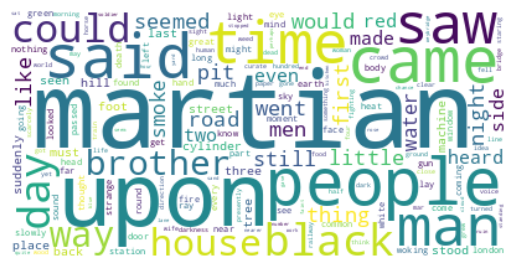

Author Name: Jules Verne


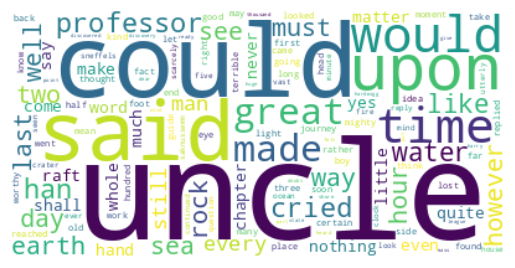

Author Name: Howard Pyle


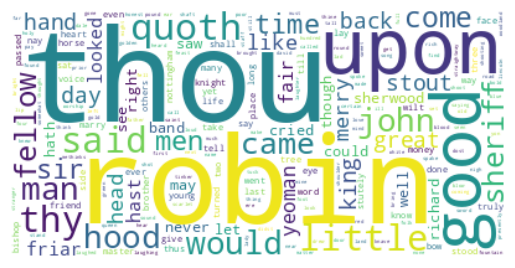

Author Name: Sir James Knowle & Sir Thomas Malory


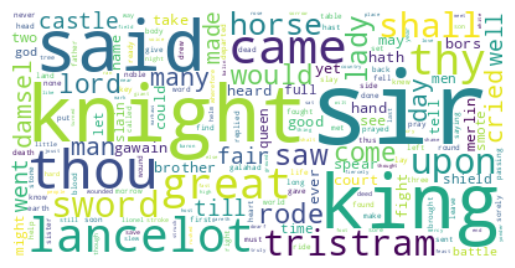

Author Name: Friedrich Wilhelm Nietzsche


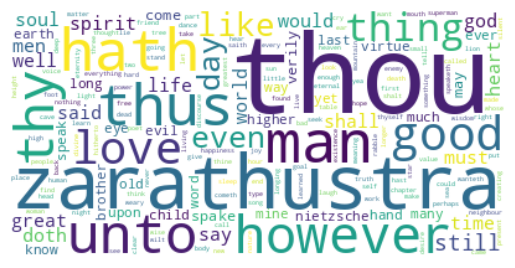

Author Name: Aristotle


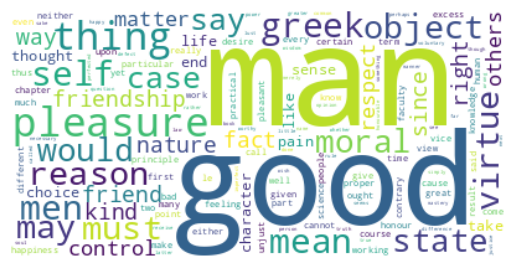

In [ ]:
#Visual display of words for each authors
word_cloud_frequency()

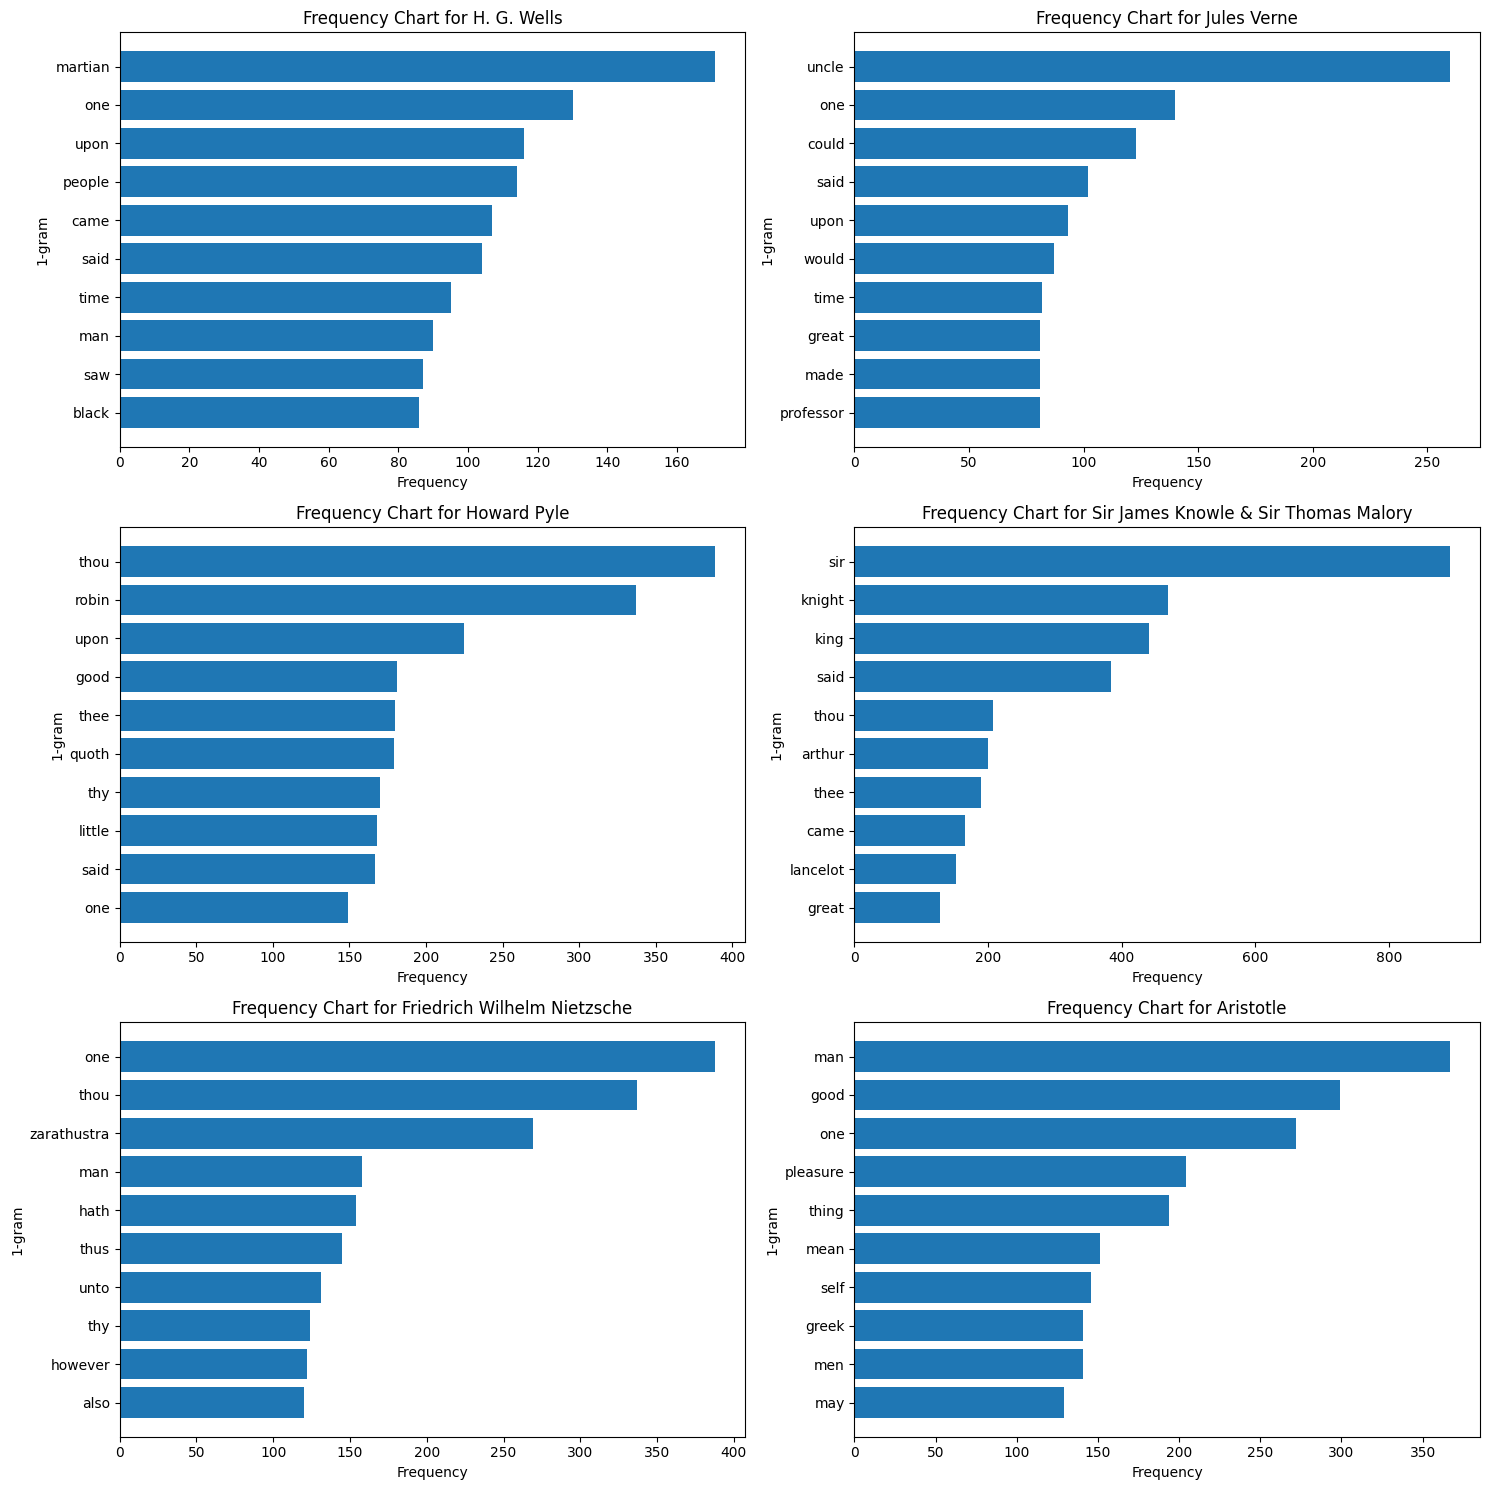

In [ ]:
fun_freqent_ngram(df= df_all_partitions, n=1)

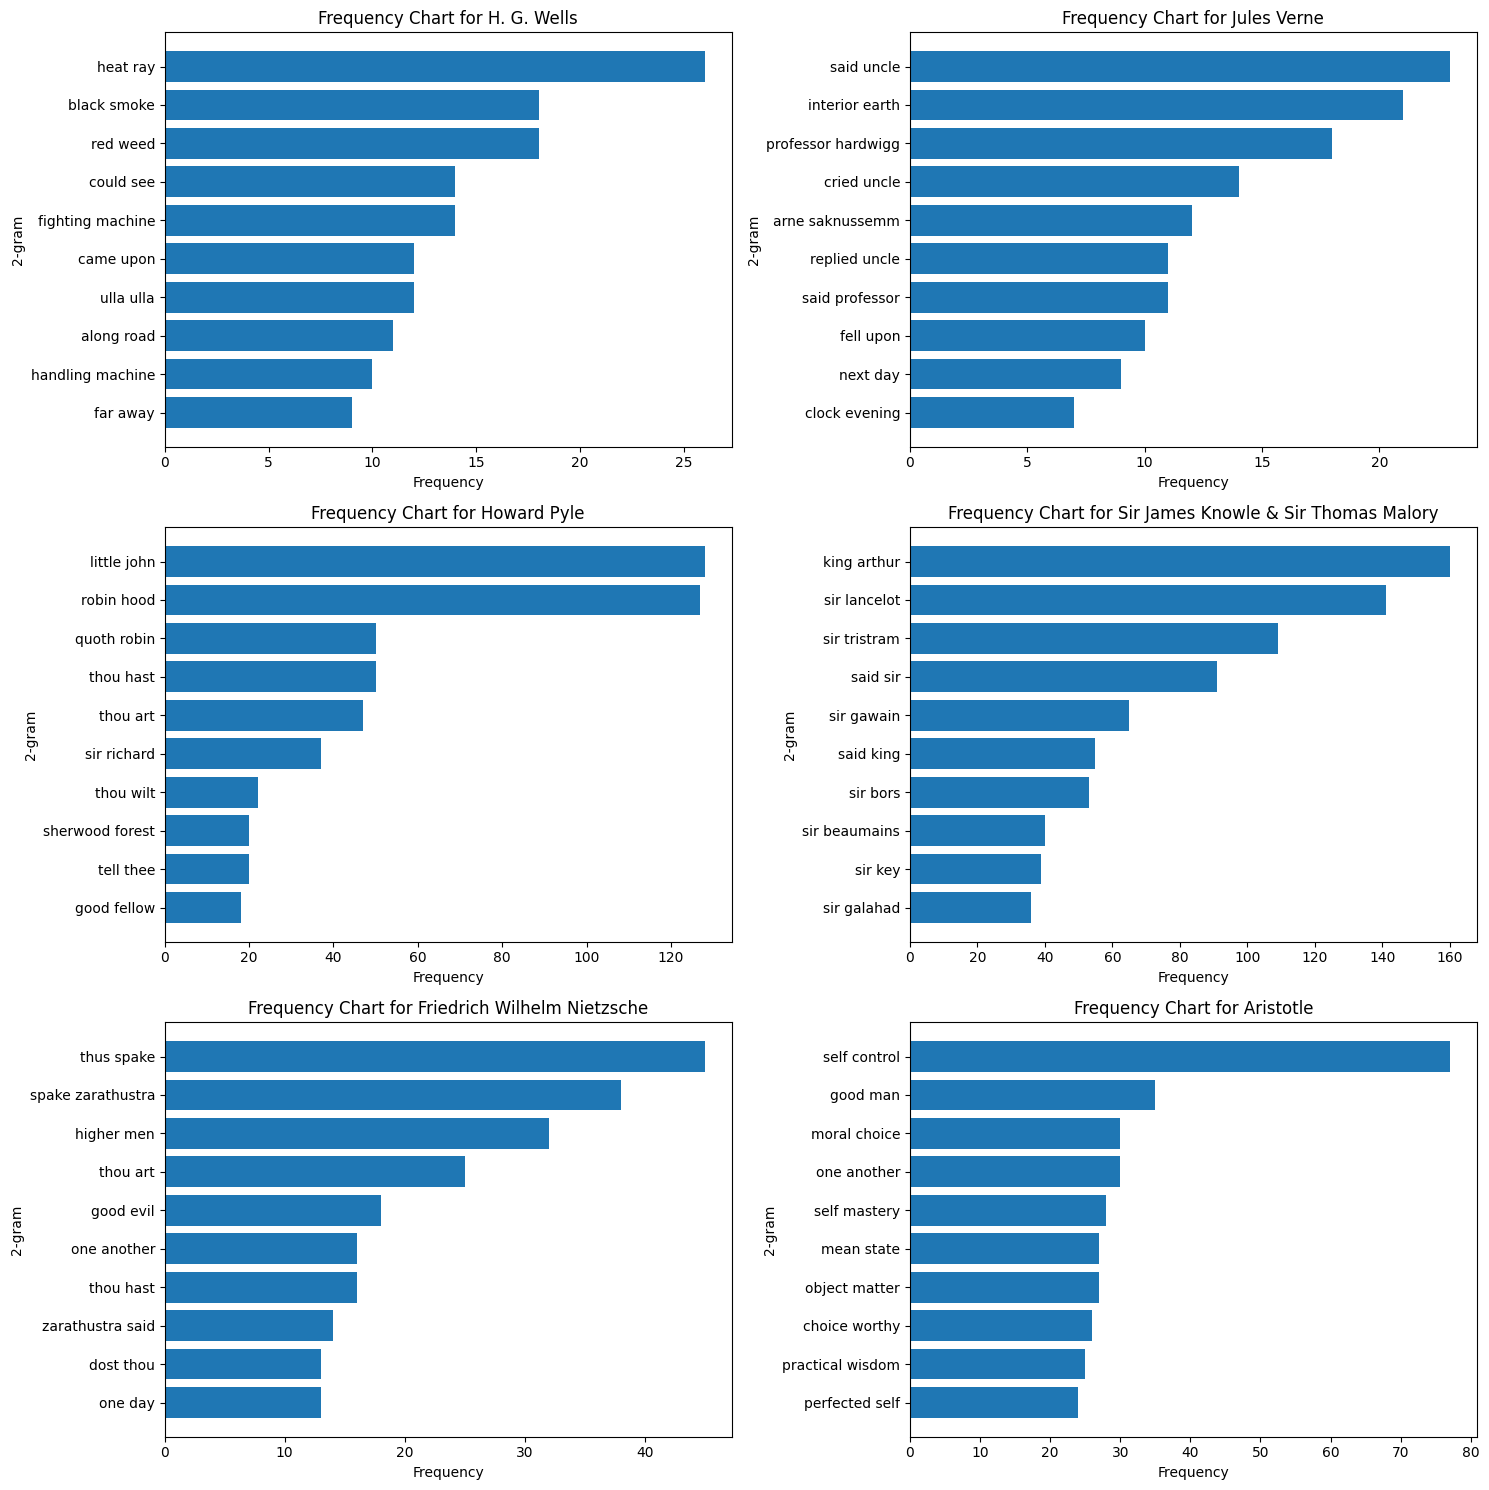

In [ ]:
fun_freqent_ngram(df= df_all_partitions, n=2)

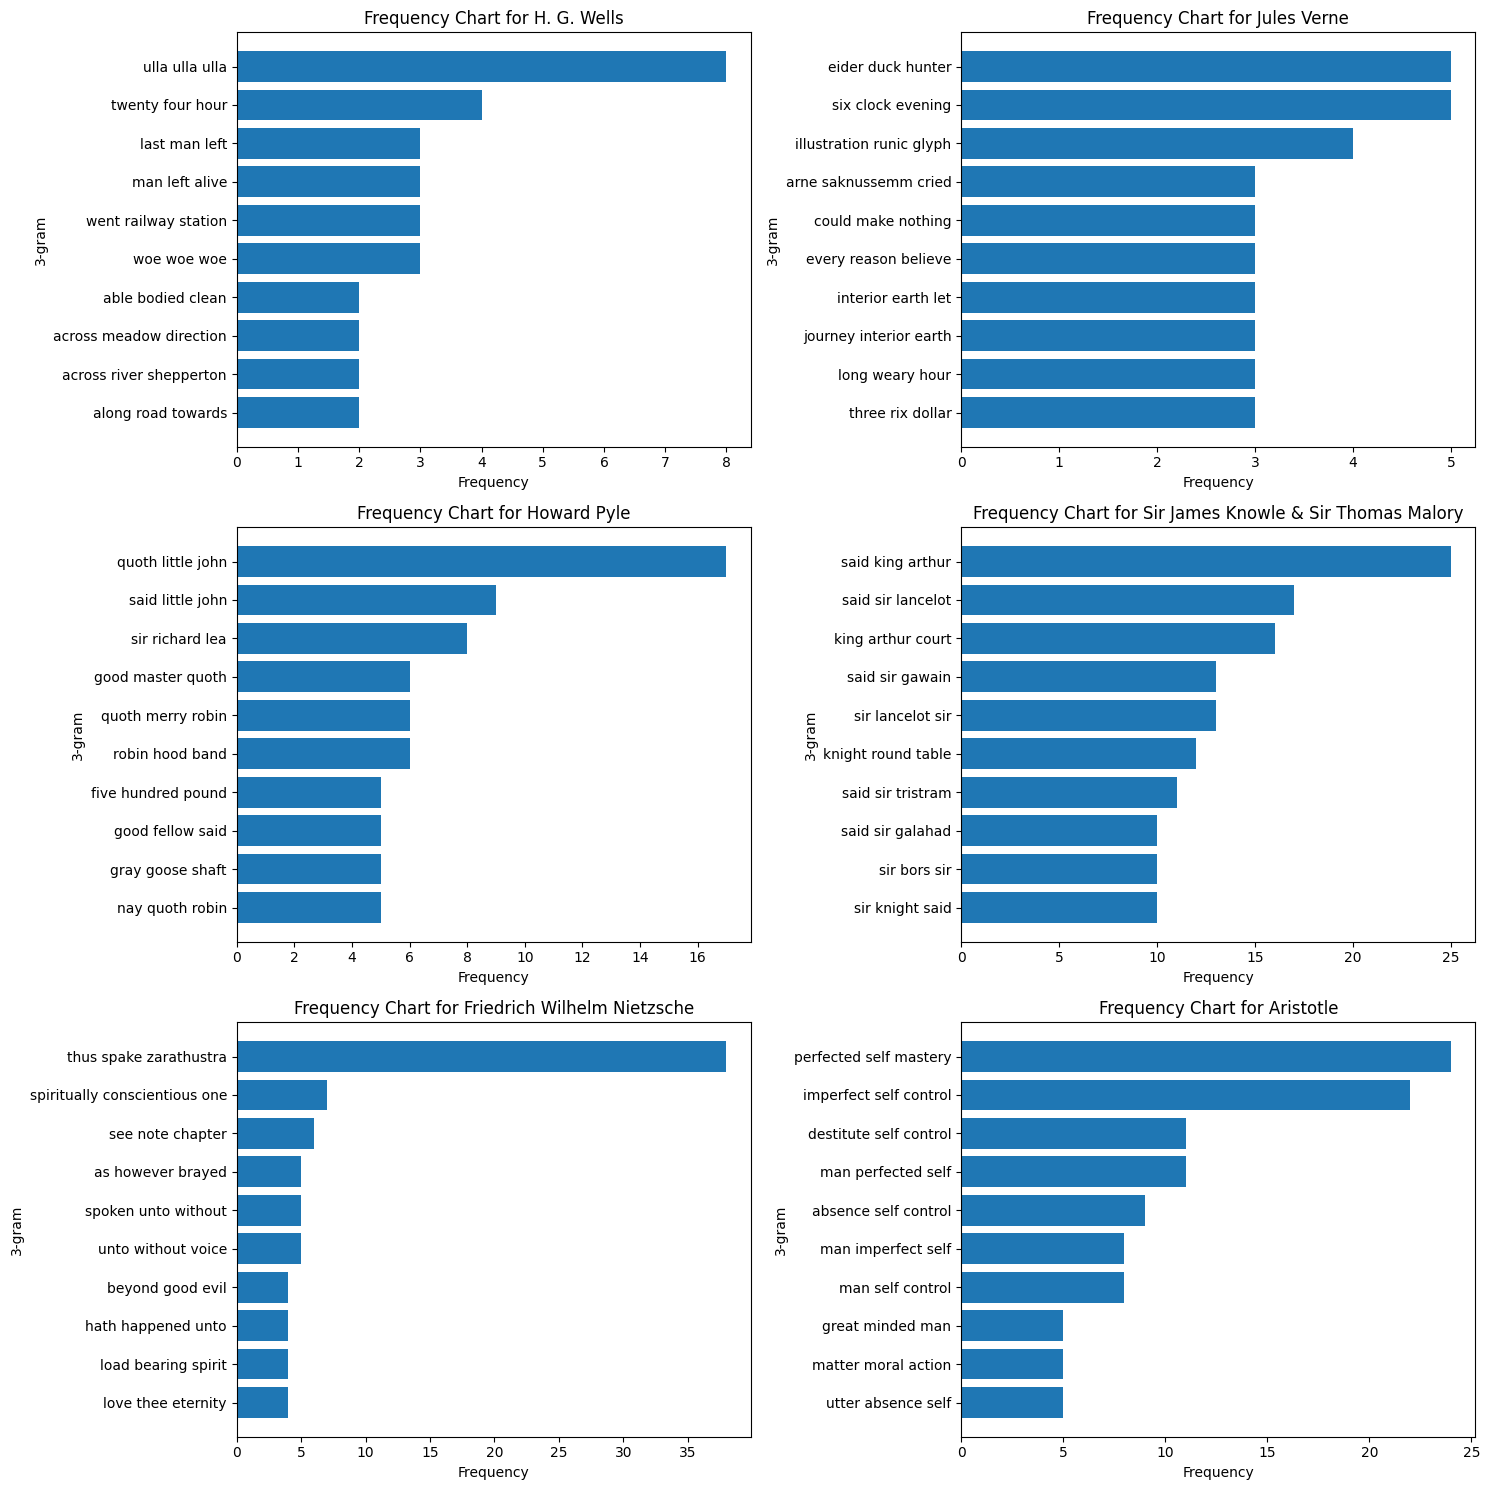

In [ ]:
fun_freqent_ngram(df= df_all_partitions, n=3)

In [6]:
#get the transformed datafram
df_bow = bow_transform()
df_tfidf = tfidf_transform()
df_3gram = ngram_transform(ngram_range = (3,3))
df_2gram = ngram_transform(ngram_range = (1,2))  # with both uni and bi gram
#have an idea about the number of features
print(df_bow.shape)
print(df_tfidf.shape)
print(df_3gram.shape)
print(df_2gram.shape)

(1200, 13273)
(1200, 13273)
(1200, 115152)
(1200, 112378)


In [ ]:
# df_2gram = ngram_transform(ngram_range = (2,2))
# df_2gram.columns

Index(['book_name', 'label', 'text', 'target_author', 'target_genre', 'abandon bottom', 'abandon horizontal', 'abandoned abandoned', 'abandoned altogether', 'abandoned argument',
       ...
       'zeal professor', 'zell adheres', 'zell quoted', 'zenith see', 'zenith superman', 'zenithward towards', 'zigzag fashion', 'zigzag rapid', 'zodiac pointed', 'zone last'], dtype='object', length=99110)

In [7]:
# split dataset into training and testing, this will take awhile, please wait with patience :)
train_x_bow, test_x_bow, train_y_bow, test_y_bow = stratified_sample(df_bow)
train_x_tfidf, test_x_tfidf, train_y_tfidf, test_y_tfidf = stratified_sample(df_tfidf)
train_x_3gram, test_x_3gram, train_y_3gram, test_y_3gram = stratified_sample(df_3gram)
train_x_2gram, test_x_2gram, train_y_2gram, test_y_2gram = stratified_sample(df_2gram)

Accuracy: 0.99

Confusion Matrix:


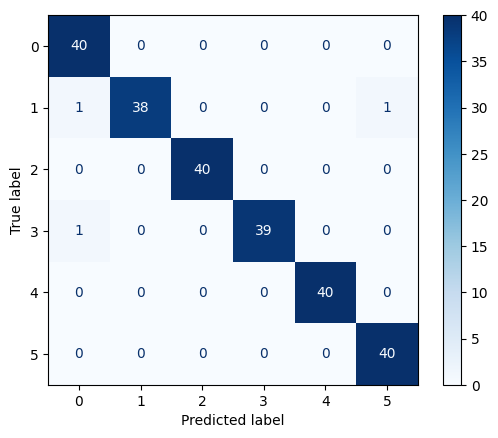

Classification Report:
                                              precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       0.95      1.00      0.98        40
                 Jules Verne_Science Fiction       1.00      0.95      0.97        40
                         Howard Pyle_Fantasy       1.00      1.00      1.00        40
Sir James Knowle & Sir Thomas Malory_Fantasy       1.00      0.97      0.99        40
      Friedrich Wilhelm Nietzsche_Philosophy       1.00      1.00      1.00        40
                        Aristotle_Philosophy       0.98      1.00      0.99        40

                                    accuracy                           0.99       240
                                   macro avg       0.99      0.99      0.99       240
                                weighted avg       0.99      0.99      0.99       240


Average expected loss: 0.015
Average bias: 0.004
Average variance: 0.014

Misclassified Obs:
                    

In [ ]:
#SVM model with BoW transformation
svm_model, misclassified_data = svm_algo(train_x = train_x_bow ,test_x = test_x_bow,train_y = train_y_bow,test_y = test_y_bow)

In [ ]:
#10 fold cross validatin of the SVM model on the BoW transformed data
print('10 fold cross validation with SVM model training on BoW transformed data')
tenF_crossval(df = df_bow, my_model = svm_model)

10 fold cross validation with SVM model training on BoW transformed data
Accuracy scores for each fold: ['0.992', '0.992', '0.950', '0.975', '0.992', '0.992', '0.992', '0.983', '0.975', '0.983']
Mean score of all folds: 0.982


In [ ]:
misclassified_data

,text,combined_label,true_label,pred_label
0,text isolated farm solitary bur icelandic h...,Jules Verne_Science Fiction,1,0
1,text throne thou sittest full twenty thousa...,Sir James Knowle & Sir Thomas Malory_Fantasy,3,0
2,text far seeing audacious among learned men...,Jules Verne_Science Fiction,1,5


Accuracy: 1.00

Confusion Matrix:


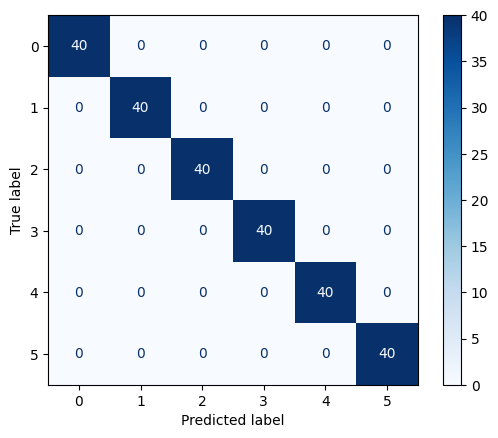

Classification Report:
                                              precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       1.00      1.00      1.00        40
                 Jules Verne_Science Fiction       1.00      1.00      1.00        40
                         Howard Pyle_Fantasy       1.00      1.00      1.00        40
Sir James Knowle & Sir Thomas Malory_Fantasy       1.00      1.00      1.00        40
      Friedrich Wilhelm Nietzsche_Philosophy       1.00      1.00      1.00        40
                        Aristotle_Philosophy       1.00      1.00      1.00        40

                                    accuracy                           1.00       240
                                   macro avg       1.00      1.00      1.00       240
                                weighted avg       1.00      1.00      1.00       240


Average expected loss: 0.002
Average bias: 0.000
Average variance: 0.002

Misclassified Obs:
Empty DataFrame
Colu

In [ ]:
#SVM model with TFIDF transformation
svm_model, misclassified_data = svm_algo(train_x = train_x_tfidf ,test_x = test_x_tfidf,train_y = train_y_tfidf,test_y = test_y_tfidf)

In [ ]:
#10 fold cross validatin of the SVM model on the TFIDF transformed data
print('10 fold cross validation with SVM model training on TFIDF transformed data')
tenF_crossval(df = df_tfidf, my_model = svm_model)

10 fold cross validation with SVM model training on TFIDF transformed data
Accuracy scores for each fold: ['1.000', '1.000', '0.992', '1.000', '1.000', '0.983', '1.000', '1.000', '0.983', '1.000']
Mean score of all folds: 0.996


Accuracy: 0.61

Confusion Matrix:


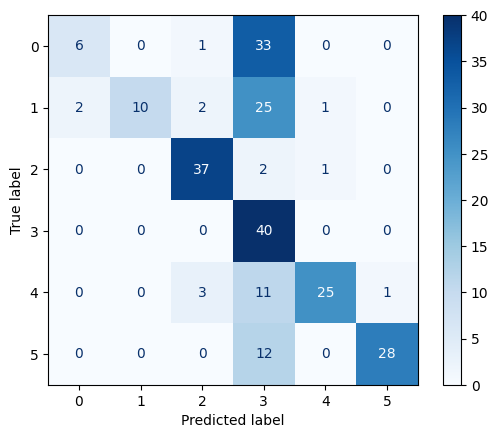

Classification Report:
                                              precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       0.75      0.15      0.25        40
                 Jules Verne_Science Fiction       1.00      0.25      0.40        40
                         Howard Pyle_Fantasy       0.86      0.93      0.89        40
Sir James Knowle & Sir Thomas Malory_Fantasy       0.33      1.00      0.49        40
      Friedrich Wilhelm Nietzsche_Philosophy       0.93      0.62      0.75        40
                        Aristotle_Philosophy       0.97      0.70      0.81        40

                                    accuracy                           0.61       240
                                   macro avg       0.80      0.61      0.60       240
                                weighted avg       0.80      0.61      0.60       240


Average expected loss: 0.407
Average bias: 0.308
Average variance: 0.349

Misclassified Obs:
                    

In [ ]:
#SVM model with Tri-gram transformation
svm_model, misclassified_data = svm_algo(train_x = train_x_3gram ,test_x = test_x_3gram,train_y = train_y_3gram,test_y = test_y_3gram)

In [ ]:
misclassified_data

In [ ]:
#10 fold cross validatin of the SVM model on the BoW transformed data
print('10 fold cross validation with SVM model training on tri-gram transformed data')
tenF_crossval(df = df_3gram, my_model = svm_model)

10 fold cross validation with SVM model training on tri-gram transformed data
Accuracy scores for each fold: ['0.617', '0.667', '0.633', '0.658', '0.617', '0.633', '0.650', '0.650', '0.708', '0.700']
Mean score of all folds: 0.653


Accuracy: 0.98

Confusion Matrix:


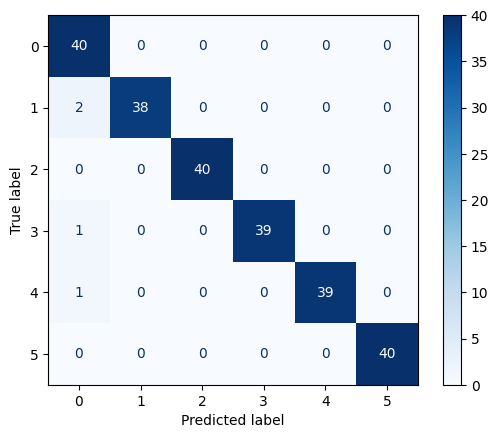

Classification Report:
                                              precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       0.91      1.00      0.95        40
                 Jules Verne_Science Fiction       1.00      0.95      0.97        40
                         Howard Pyle_Fantasy       1.00      1.00      1.00        40
Sir James Knowle & Sir Thomas Malory_Fantasy       1.00      0.97      0.99        40
      Friedrich Wilhelm Nietzsche_Philosophy       1.00      0.97      0.99        40
                        Aristotle_Philosophy       1.00      1.00      1.00        40

                                    accuracy                           0.98       240
                                   macro avg       0.98      0.98      0.98       240
                                weighted avg       0.98      0.98      0.98       240


Average expected loss: 0.016
Average bias: 0.004
Average variance: 0.014

Misclassified Obs:
                    

In [8]:
#SVM model with Bi-gram transformation
svm_model, misclassified_data = svm_algo(train_x = train_x_2gram ,test_x = test_x_2gram,train_y = train_y_2gram,test_y = test_y_2gram)

In [ ]:
#10 fold cross validatin of the SVM model on the bi-gram transformed data
print('10 fold cross validation with SVM model training on bi-gram transformed data')
tenF_crossval(df = df_2gram, my_model = svm_model)

10 fold cross validation with SVM model training on bi-gram transformed data
Accuracy scores for each fold: ['0.975', '1.000', '0.975', '0.983', '0.992', '0.992', '0.983', '1.000', '0.983', '1.000']
Mean score of all folds: 0.988


Accuracy: 1.00

Confusion Matrix:


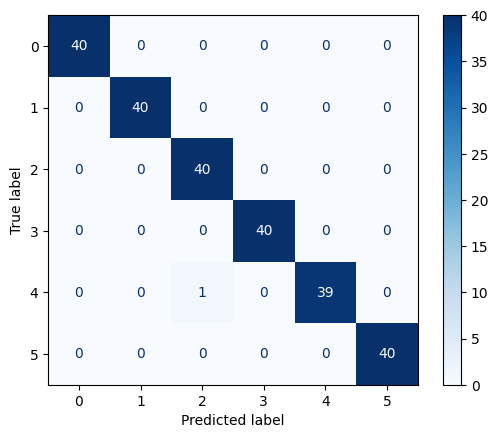

Classification Report:
                                              precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       1.00      1.00      1.00        40
                 Jules Verne_Science Fiction       1.00      1.00      1.00        40
                         Howard Pyle_Fantasy       0.98      1.00      0.99        40
Sir James Knowle & Sir Thomas Malory_Fantasy       1.00      1.00      1.00        40
      Friedrich Wilhelm Nietzsche_Philosophy       1.00      0.97      0.99        40
                        Aristotle_Philosophy       1.00      1.00      1.00        40

                                    accuracy                           1.00       240
                                   macro avg       1.00      1.00      1.00       240
                                weighted avg       1.00      1.00      1.00       240


Average expected loss: 0.006
Average bias: 0.004
Average variance: 0.003

Misclassified Obs:
                    

In [ ]:
#Naive Bayes model with BoW transformation
nb_model, misclassified_data = naive_bayes_algo(train_x = train_x_bow ,test_x = test_x_bow,train_y = train_y_bow,test_y = test_y_bow)

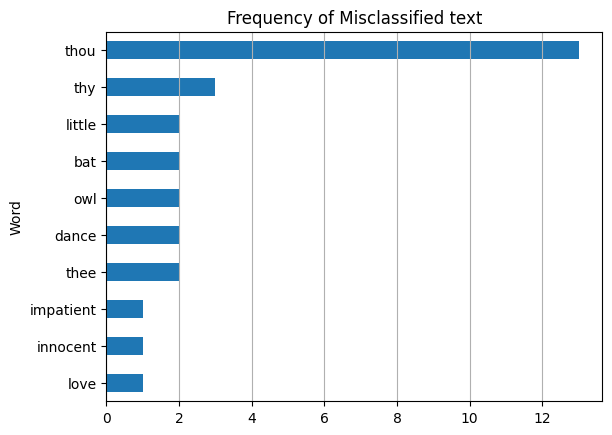

In [ ]:
misclassified_data['text'] = misclassified_data['text'].astype(str)

top = 10
corpus = misclassified_data['text']
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(),
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Frequency of Misclassified text",
                  legend=False).grid(axis='x')

In [ ]:
#10 fold cross validatin of the Naive Bayes model on the BoW transformed data
tenF_crossval(df = df_bow, my_model = nb_model)

Accuracy scores for each fold: ['1.000', '0.992', '0.983', '1.000', '1.000', '1.000', '1.000', '0.983', '0.992', '1.000']
Mean score of all folds: 0.995


Accuracy: 1.00

Confusion Matrix:


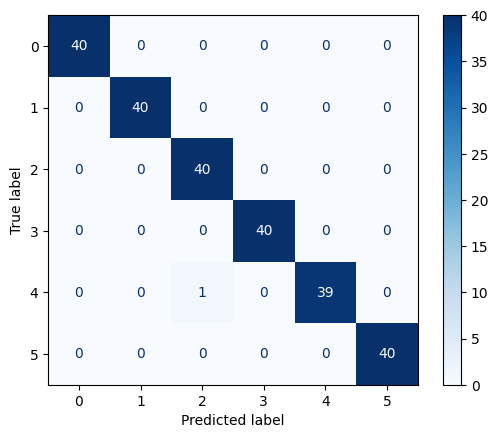

Classification Report:
                                              precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       1.00      1.00      1.00        40
                 Jules Verne_Science Fiction       1.00      1.00      1.00        40
                         Howard Pyle_Fantasy       0.98      1.00      0.99        40
Sir James Knowle & Sir Thomas Malory_Fantasy       1.00      1.00      1.00        40
      Friedrich Wilhelm Nietzsche_Philosophy       1.00      0.97      0.99        40
                        Aristotle_Philosophy       1.00      1.00      1.00        40

                                    accuracy                           1.00       240
                                   macro avg       1.00      1.00      1.00       240
                                weighted avg       1.00      1.00      1.00       240


Average expected loss: 0.009
Average bias: 0.004
Average variance: 0.007

Misclassified Obs:
                    

In [ ]:
#Naive Bayes model, TFIDF data
nb_model, misclassified_data = naive_bayes_algo(train_x = train_x_tfidf ,test_x = test_x_tfidf,train_y = train_y_tfidf,test_y = test_y_tfidf)

In [ ]:
#10 fold cross validatin of the Naive Bayes model on the TFODF transformed data
print('10 fold cross validation with Naive Bayes model training on TFIDF transformed data')
tenF_crossval(df = df_tfidf, my_model = nb_model)

10 fold cross validation with Naive Bayes model training on TFIDF transformed data
Accuracy scores for each fold: ['1.000', '0.983', '0.983', '0.992', '1.000', '1.000', '1.000', '0.983', '0.983', '1.000']
Mean score of all folds: 0.992


Accuracy: 0.75

Confusion Matrix:


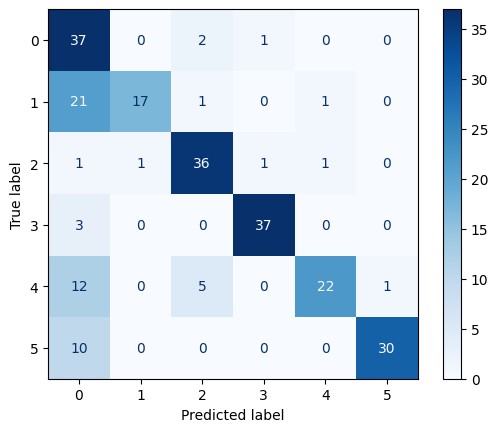

Classification Report:
                                              precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       0.44      0.93      0.60        40
                 Jules Verne_Science Fiction       0.94      0.42      0.59        40
                         Howard Pyle_Fantasy       0.82      0.90      0.86        40
Sir James Knowle & Sir Thomas Malory_Fantasy       0.95      0.93      0.94        40
      Friedrich Wilhelm Nietzsche_Philosophy       0.92      0.55      0.69        40
                        Aristotle_Philosophy       0.97      0.75      0.85        40

                                    accuracy                           0.75       240
                                   macro avg       0.84      0.75      0.75       240
                                weighted avg       0.84      0.75      0.75       240


Average expected loss: 0.487
Average bias: 0.350
Average variance: 0.444

Misclassified Obs:
                    

In [ ]:
#Naive Bayes model with tri-gram transformation
nb_model, misclassified_data = naive_bayes_algo(train_x = train_x_3gram ,test_x = test_x_3gram,train_y = train_y_3gram,test_y = test_y_3gram)

In [ ]:
misclassified_data

,text,combined_label,true_label,pred_label
0,vine loaded rich grape certainly ordinary aspe...,Jules Verne_Science Fiction,1,0
1,fortune presume becomingly always noblest circ...,Aristotle_Philosophy,5,0
2,laid nothing precipitately noted question pers...,H. G. Wells_Science Fiction,0,3
3,way cast filth blind one course disgusted old ...,Friedrich Wilhelm Nietzsche_Philosophy,4,0
4,two greatest modern evolutionist darwin spence...,Friedrich Wilhelm Nietzsche_Philosophy,4,0
5,semblance deceive delightfully smallest gap di...,Friedrich Wilhelm Nietzsche_Philosophy,4,0
6,icelandic sure uncle ought known perfect polyg...,Jules Verne_Science Fiction,1,0
7,training master vain counselled time become th...,Friedrich Wilhelm Nietzsche_Philosophy,4,0
8,thyself thy ruling thought would hear thou has...,Friedrich Wilhelm Nietzsche_Philosophy,4,2
9,overslept reptile voice shall soon crow thee a...,Friedrich Wilhelm Nietzsche_Philosophy,4,2


In [ ]:
#10 fold cross validatin of the Naive Bayes model on the tri-gram transformed data
print('10 fold cross validation with Naive Bayes model training on tri-gram transformed data')
tenF_crossval(df = df_3gram, my_model = nb_model)

10 fold cross validation with Naive Bayes model training on tri-gram transformed data
Accuracy scores for each fold: ['0.767', '0.792', '0.750', '0.750', '0.767', '0.792', '0.783', '0.717', '0.775', '0.733']
Mean score of all folds: 0.763


Accuracy: 1.00

Confusion Matrix:


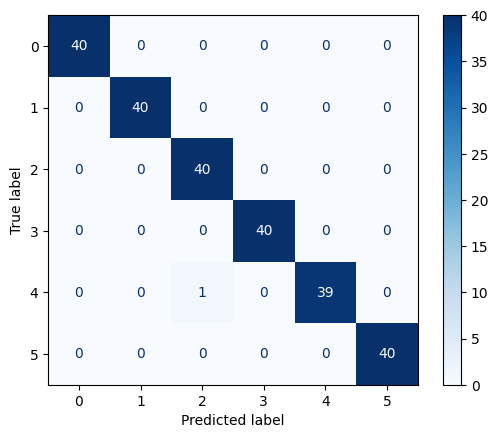

Classification Report:
                                              precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       1.00      1.00      1.00        40
                 Jules Verne_Science Fiction       1.00      1.00      1.00        40
                         Howard Pyle_Fantasy       0.98      1.00      0.99        40
Sir James Knowle & Sir Thomas Malory_Fantasy       1.00      1.00      1.00        40
      Friedrich Wilhelm Nietzsche_Philosophy       1.00      0.97      0.99        40
                        Aristotle_Philosophy       1.00      1.00      1.00        40

                                    accuracy                           1.00       240
                                   macro avg       1.00      1.00      1.00       240
                                weighted avg       1.00      1.00      1.00       240


Average expected loss: 0.006
Average bias: 0.004
Average variance: 0.004

Misclassified Obs:
                    

In [ ]:
#Naive Bayes model with bi-gram transformation
nb_model, misclassified_data = naive_bayes_algo(train_x = train_x_2gram ,test_x = test_x_2gram,train_y = train_y_2gram,test_y = test_y_2gram)

In [ ]:
#10 fold cross validatin of the Naive Bayes model on the bigram transformed data
print('10 fold cross validation with Naive Bayes model training on bi-gram transformed data')
tenF_crossval(df = df_2gram, my_model = nb_model)

10 fold cross validation with Naive Bayes model training on bi-gram transformed data
Accuracy scores for each fold: ['1.000', '0.992', '0.975', '1.000', '1.000', '1.000', '1.000', '0.992', '0.992', '1.000']
Mean score of all folds: 0.995


Accuracy of XGBoost mdoel with TFIDF transformation: 0.97
Confusion Matrix:


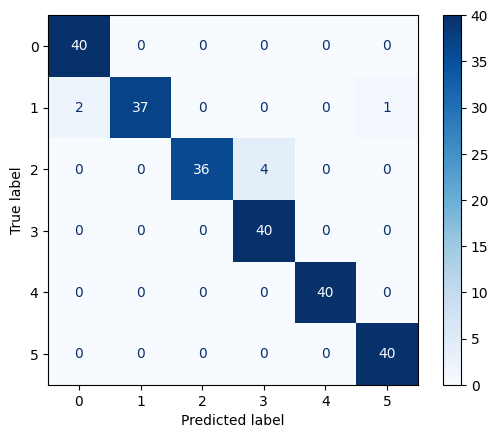

Classification Report:
                                               precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       0.95      1.00      0.98        40
                 Jules Verne_Science Fiction       1.00      0.93      0.96        40
                         Howard Pyle_Fantasy       1.00      0.90      0.95        40
Sir James Knowle & Sir Thomas Malory_Fantasy       0.91      1.00      0.95        40
      Friedrich Wilhelm Nietzsche_Philosophy       1.00      1.00      1.00        40
                        Aristotle_Philosophy       0.98      1.00      0.99        40

                                    accuracy                           0.97       240
                                   macro avg       0.97      0.97      0.97       240
                                weighted avg       0.97      0.97      0.97       240


Average expected loss: 0.041
Average bias: 0.025
Average variance: 0.026
                                       

In [ ]:
#XGBoost model with BoW transformation
xgb_model, misclassified_data = xgboost_algo(train_x = train_x_bow ,test_x = test_x_bow,train_y = train_y_bow,test_y = test_y_bow)

In [ ]:
print('10 fold cross validation with XG-Boost model training on BoW transformed data')
tenF_crossval(df = df_bow, my_model = xgb_model)

10 fold cross validation with XG-Boost model training on BoW transformed data
Accuracy scores for each fold: ['0.992', '0.975', '0.958', '0.967', '0.958', '0.983', '0.958', '0.983', '0.983', '0.958']
Mean score of all folds: 0.972


Accuracy of XGBoost mdoel with TFIDF transformation: 0.97
Confusion Matrix:


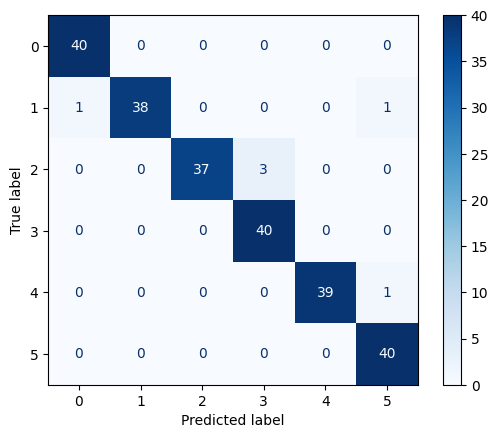

Classification Report:
                                               precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       0.98      1.00      0.99        40
                 Jules Verne_Science Fiction       1.00      0.95      0.97        40
                         Howard Pyle_Fantasy       1.00      0.93      0.96        40
Sir James Knowle & Sir Thomas Malory_Fantasy       0.93      1.00      0.96        40
      Friedrich Wilhelm Nietzsche_Philosophy       1.00      0.97      0.99        40
                        Aristotle_Philosophy       0.95      1.00      0.98        40

                                    accuracy                           0.97       240
                                   macro avg       0.98      0.97      0.97       240
                                weighted avg       0.98      0.97      0.97       240


Average expected loss: 0.046
Average bias: 0.021
Average variance: 0.031
                                       

In [ ]:
#XGBoost model with TFIDF transformation, the bias_variance_decomp takes awhile to finishing runnning
xgb_model, misclassified_data = xgboost_algo(train_x = train_x_tfidf ,test_x = test_x_tfidf,train_y = train_y_tfidf,test_y = test_y_tfidf)

In [ ]:
print('10 fold cross validation with XG-Boost model training on tfidf transformed data')
tenF_crossval(df = df_tfidf, my_model = xgb_model)

10 fold cross validation with XG-Boost model training on tfidf transformed data
Accuracy scores for each fold: ['0.975', '0.967', '0.950', '0.950', '0.967', '0.967', '0.967', '0.983', '0.967', '0.942']
Mean score of all folds: 0.963


In [ ]:
#XGBoost model with TRI-GRAM transformation
# set up model train as call xgboost_algo will result in RAM unavailable, you could try call xgboost_algo function if you have enough RAM
xgbc_3model = XGBClassifier(objective='multi:softprob').fit(train_x_3gram.drop(['combined_label','text'], axis=1), train_y_3gram)
y_pred = xgbc_3model.predict(test_x_3gram.drop(['combined_label','text'], axis=1))

# Evaluate the model
print('Accuracy of XGBoost mdoel with TFIDF transformation: {:.2f}'.format(accuracy_score(test_y_3gram, y_pred)))

print("Classification Report:\n",classification_report(test_y_3gram, y_pred,
                                                       target_names= ['H. G. Wells_Science Fiction', 'Jules Verne_Science Fiction','Howard Pyle_Fantasy',
                                   'Sir James Knowle & Sir Thomas Malory_Fantasy',
                                  'Friedrich Wilhelm Nietzsche_Philosophy','Aristotle_Philosophy']))
#xgb_model, misclassified_data = xgboost_algo(train_x = train_x_3gram ,test_x = test_x_3gram,train_y = train_y_3gram,test_y = test_y_3gram)
#can't get the bias_variance_decomp due to ram limits

Accuracy of XGBoost mdoel with TFIDF transformation: 0.36
Classification Report:
                                               precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       0.21      1.00      0.35        40
                 Jules Verne_Science Fiction       0.20      0.03      0.04        40
                         Howard Pyle_Fantasy       1.00      0.35      0.52        40
Sir James Knowle & Sir Thomas Malory_Fantasy       1.00      0.50      0.67        40
      Friedrich Wilhelm Nietzsche_Philosophy       1.00      0.17      0.30        40
                        Aristotle_Philosophy       1.00      0.10      0.18        40

                                    accuracy                           0.36       240
                                   macro avg       0.74      0.36      0.34       240
                                weighted avg       0.74      0.36      0.34       240



In [ ]:
#can't get results due to RAM limits, session crashed after using all available RAM
print('10 fold cross validation with XG-Boost model training on TRI-GRAM transformed data')
tenF_crossval(df = df_3gram, my_model = xgbc_3model)

In [ ]:
#XGBoost model with BI-GRAM transformation
# set up model train as call xgboost_algo will result in RAM unavailable, you could try call xgboost_algo function if you have enough RAM
xgbc_model = XGBClassifier(objective='multi:softprob').fit(train_x_2gram.drop(['combined_label','text'], axis=1), train_y_2gram)
y_pred = xgbc_model.predict(test_x_2gram.drop(['combined_label','text'], axis=1))

# Evaluate the model
print('Accuracy of XGBoost mdoel with TFIDF transformation: {:.2f}'.format(accuracy_score(test_y_2gram, y_pred)))

print("Classification Report:\n",classification_report(test_y_2gram, y_pred,
                                                       target_names= ['H. G. Wells_Science Fiction', 'Jules Verne_Science Fiction','Howard Pyle_Fantasy',
                                   'Sir James Knowle & Sir Thomas Malory_Fantasy',
                                  'Friedrich Wilhelm Nietzsche_Philosophy','Aristotle_Philosophy']))
#xgb_model, misclassified_data = xgboost_algo(train_x = train_x_2gram ,test_x = test_x_2gram,train_y = train_y_2gram,test_y = test_y_2gram)

Accuracy of XGBoost mdoel with TFIDF transformation: 0.97
Classification Report:
                                               precision    recall  f1-score   support

                 H. G. Wells_Science Fiction       0.98      1.00      0.99        40
                 Jules Verne_Science Fiction       1.00      0.93      0.96        40
                         Howard Pyle_Fantasy       0.97      0.93      0.95        40
Sir James Knowle & Sir Thomas Malory_Fantasy       0.93      1.00      0.96        40
      Friedrich Wilhelm Nietzsche_Philosophy       0.97      0.97      0.97        40
                        Aristotle_Philosophy       0.98      1.00      0.99        40

                                    accuracy                           0.97       240
                                   macro avg       0.97      0.97      0.97       240
                                weighted avg       0.97      0.97      0.97       240



In [ ]:
#can't get results due to RAM limits, session crashed after using all available RAM
# print('10 fold cross validation with XG-Boost model training on BI-GRAM transformed data')
# tenF_crossval(df = df_2gram, my_model = xgbc_model)

10 fold cross validation with XG-Boost model training on BI-GRAM transformed data


In [ ]:
# for Random forest, KNN and SGD models, pipeline is leveraged to simplify the code
# Define the ColumnTransformer for preprocessing features
# All features are numerical (transformed into numerical values)
# 1 - Bow DATA
def train_evaluate_model(x_train, x_test, y_train, y_test, model, model_name, my_df):
    x_train = x_train.drop(['combined_label','text'], axis=1)
    x_test = x_test.drop(['combined_label','text'], axis=1)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Display evaluation metrics
    print(f'{model_name} - Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(f'{model_name} - Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
    print(f'{model_name} - Classification Report:\n{classification_report(y_test, y_pred)}')
    # Display the avg. loss, avg. bias and avg. variance
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, np.array(x_train),
                                                                np.array(y_train), np.array(x_test),
                                                                np.array(y_test),
                                                                loss='0-1_loss', random_seed=123, num_rounds = 20)

    print(f'{model_name} - Average expected loss: %.3f' % avg_expected_loss)
    print(f'{model_name} - Average bias: %.3f' % avg_bias)
    print(f'{model_name} - Average variance: %.3f' % avg_var)
    print('')
    tenF_crossval(df = my_df, my_model = model)

# Define a common preprocessing step (StandardScaler)
# All features are numerical (transformed into numerical values)
preprocessor = StandardScaler()

# Define individual models, define the number of trees in the forest equal to 50.
rf_model = RandomForestClassifier(n_estimators= 50, random_state= 10)
knn_model = KNeighborsClassifier() #default n_neighborsint=5
sgd_model = SGDClassifier(random_state=10)
# Create a pipeline for each model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', knn_model)
])

sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', sgd_model)
])

# Train and evaluate models for BoW transformed data
train_evaluate_model(x_train= train_x_bow, x_test= test_x_bow, y_train = train_y_bow, y_test = test_y_bow,
                     model=rf_pipeline, model_name='Random Forest - BoW Transformed Data',
                     my_df = df_bow)
train_evaluate_model(x_train= train_x_bow, x_test= test_x_bow, y_train = train_y_bow, y_test = test_y_bow,
                     model = knn_pipeline, model_name='k-Nearest Neighbors - BoW Transformed Data',
                     my_df = df_bow)
train_evaluate_model(x_train= train_x_bow, x_test= test_x_bow, y_train = train_y_bow, y_test = test_y_bow,
                     model = sgd_pipeline, model_name='SGD - BoW Transformed Data',
                     my_df = df_bow)


Random Forest - BoW Transformed Data - Accuracy: 0.98
Random Forest - BoW Transformed Data - Confusion Matrix:
[[40  0  0  0  0  0]
 [ 1 37  0  0  0  2]
 [ 0  0 40  0  0  0]
 [ 0  0  0 40  0  0]
 [ 0  0  0  0 39  1]
 [ 0  0  0  0  0 40]]
Random Forest - BoW Transformed Data - Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      0.93      0.96        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       1.00      0.97      0.99        40
           5       0.93      1.00      0.96        40

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240

Random Forest - BoW Transformed Data - Average expected loss: 0.023
Random Forest - BoW Transformed Data - Average bias: 0.004
Random Forest - BoW Transforme

In [ ]:
# Train and evaluate models for TFIDF transformed data
train_evaluate_model(x_train= train_x_tfidf, x_test= test_x_tfidf, y_train = train_y_tfidf, y_test = test_y_tfidf,
                     model=rf_pipeline, model_name='Random Forest - TFIDF Transformed Data',
                     my_df = df_tfidf)
train_evaluate_model(x_train= train_x_tfidf, x_test= test_x_tfidf, y_train = train_y_tfidf, y_test = test_y_tfidf,
                     model = knn_pipeline, model_name='k-Nearest Neighbors - TFIDF Transformed Data',
                     my_df = df_tfidf)
train_evaluate_model(x_train= train_x_tfidf, x_test= test_x_tfidf, y_train = train_y_tfidf, y_test = test_y_tfidf,
                     model = sgd_pipeline, model_name='SGD - TFIDF Transformed Data',
                     my_df = df_tfidf)

Random Forest - TFIDF Transformed Data - Accuracy: 0.98
Random Forest - TFIDF Transformed Data - Confusion Matrix:
[[40  0  0  0  0  0]
 [ 2 37  0  0  0  1]
 [ 0  0 39  1  0  0]
 [ 0  0  0 40  0  0]
 [ 0  0  0  0 39  1]
 [ 0  0  0  0  0 40]]
Random Forest - TFIDF Transformed Data - Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       1.00      0.93      0.96        40
           2       1.00      0.97      0.99        40
           3       0.98      1.00      0.99        40
           4       1.00      0.97      0.99        40
           5       0.95      1.00      0.98        40

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240

Random Forest - TFIDF Transformed Data - Average expected loss: 0.022
Random Forest - TFIDF Transformed Data - Average bias: 0.008
Random Forest - TFID

In [ ]:
# Train and evaluate models for bi-gram transformed data
# tri-gram transfomred data resulted in low accuracy when testing SVM/Naive Bayes/XGBoost models, thus will not test on this dataset
train_evaluate_model(x_train= train_x_2gram, x_test= test_x_2gram, y_train = train_y_2gram, y_test = test_y_2gram,
                     model=rf_pipeline, model_name='Random Forest - bigram Transformed Data',
                     my_df = df_2gram)
train_evaluate_model(x_train= train_x_2gram, x_test= test_x_2gram, y_train = train_y_2gram, y_test = test_y_2gram,
                     model = knn_pipeline, model_name='k-Nearest Neighbors - bigram Transformed Data',
                     my_df = df_2gram)
train_evaluate_model(x_train= train_x_2gram, x_test= test_x_2gram, y_train = train_y_2gram, y_test = test_y_2gram,
                     model = sgd_pipeline, model_name='SGD - bigram Transformed Data',
                     my_df = df_2gram)

Random Forest - bigram Transformed Data - Accuracy: 0.98
Random Forest - bigram Transformed Data - Confusion Matrix:
[[40  0  0  0  0  0]
 [ 0 38  0  0  0  2]
 [ 0  0 39  1  0  0]
 [ 0  0  1 39  0  0]
 [ 1  0  0  0 39  0]
 [ 0  0  0  0  0 40]]
Random Forest - bigram Transformed Data - Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      0.95      0.97        40
           2       0.97      0.97      0.97        40
           3       0.97      0.97      0.97        40
           4       1.00      0.97      0.99        40
           5       0.95      1.00      0.98        40

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240

Random Forest - bigram Transformed Data - Average expected loss: 0.030
Random Forest - bigram Transformed Data - Average bias: 0.000
Random Forest -

In [ ]:
#explore BERT (Bidirectional Encoder Representations from Transformers)
#note: BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from tqdm import tqdm

In [ ]:
# Load the BERT tokenizer and model
df_bert = df_all_partitions.copy(deep=True)
df_bert['combined_label'] = df_bert['target_author'].astype(str) + '_' + df_bert['target_genre'].astype(str)
df_bert['encoded_label'] = df_bert['combined_label'].replace(['H. G. Wells_Science Fiction', 'Jules Verne_Science Fiction','Howard Pyle_Fantasy',
                                   'Sir James Knowle & Sir Thomas Malory_Fantasy',
                                  'Friedrich Wilhelm Nietzsche_Philosophy','Aristotle_Philosophy'],
                        [0,1,2,3,4,5], inplace=False)
# initialize bert based model (language is english)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
number_labels = len(df_bert['encoded_label'].unique())
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels= number_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df_bert.columns

Index(['book_name', 'label', 'text', 'target_author', 'target_genre', 'combined_label', 'encoded_label'], dtype='object')

In [ ]:
# Tokenize and encode the text data
def tokenize_data(df, max_length=256):
    tokenized_data = tokenizer(df['text'].tolist(), max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
    labels = torch.tensor(df['encoded_label'].tolist())
    return tokenized_data, labels

In [ ]:
train_x, test_x = train_test_split(df_bert[['text','encoded_label']],test_size=0.2,
                                   stratify = df_bert['encoded_label'], random_state= 10)
train_tokenized_data, train_labels = tokenize_data(train_x)
test_tokenized_data, test_labels = tokenize_data(test_x)

In [ ]:
#print(train_x['encoded_label'].value_counts())
# Create DataLoader for training and testing data
train_dataset = TensorDataset(train_tokenized_data['input_ids'], train_tokenized_data['attention_mask'], train_labels)
test_dataset = TensorDataset(test_tokenized_data['input_ids'], test_tokenized_data['attention_mask'], test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define the optimizer (AdamW is used, AdamW optimization is a stochastic gradient descent method) and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_loss}")

# Evaluation loop
model.eval()
with torch.no_grad():
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        correct_predictions += (predictions == labels).sum().item()
        total_samples += len(labels)

accuracy = correct_predictions / total_samples
print(f"Accuracy on Test Set: {accuracy * 100:.2f}%")

Epoch 1/3: 100%|██████████| 60/60 [44:31<00:00, 44.53s/it]


Epoch 1/3, Average Training Loss: 1.134939230978489


Epoch 2/3: 100%|██████████| 60/60 [43:28<00:00, 43.48s/it]


Epoch 2/3, Average Training Loss: 0.2548515071471532


Epoch 3/3: 100%|██████████| 60/60 [43:32<00:00, 43.55s/it]


Epoch 3/3, Average Training Loss: 0.07898244373500347


Evaluating: 100%|██████████| 15/15 [03:22<00:00, 13.51s/it]

Accuracy on Test Set: 98.33%
